$\textbf{INTRO}$

Nello scaling dei sistemi di QC c'é concentrazione esponenziale della Loss Function in funzione dei parametri (Barren Plateu). Ciò significa che nello spazio dei parametri, la funzione di loss ha un gradiente che va come un esponenziale. Dunque tende a essere molto piatto in tutto lo spazio dei parametri e a convergere velocemente in un unico punto. Quando è presente rumore, la LF non può essere descritta e ottimizzata in PQC con la notazione standard di Lie.

VQC $\rightarrow$ iterativamente ottimizzazione di PQC $\rightarrow$ Minimizzare $\text{Loss}$ dato $\hat{\rho}$.

In ultima analisi, il problema sorge dalla dimensionalità (la small angle initialization è una soluzione comune). I BP possono essere indotti anche da noise ambientale e decoerenza (NIBP).

2-design nella computazione quantistica si riferisce a un insieme di stati quantistici o unità che imitano le proprietà statistiche di stati o unità veramente casuali fino al secondo momento (varianza).



In [32]:
import qiskit
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

print("Qiskit version:", qiskit.__version__)
print("PennyLane version:", qml.__version__)

Qiskit version: 1.2.4
PennyLane version: 0.38.0


$\textbf{PQC}$

I Parameterized Quantum Circuits (PQC) sono circuiti quantistici con parametri variabili, spesso utilizzati in algoritmi ibridi quantistici-classici per affrontare problemi computazionali. Essi rappresentano un ponte tra il calcolo quantistico e l’ottimizzazione classica, costituendo un elemento fondamentale nelle applicazioni quantistiche moderne, come Algoritmi Quantistici Variazionali e Modelli di Machine Learning Quantistico.

Le componenti chiave sono Gate Parametrizzati (Porte quantistiche con angoli regolabili) e un ciclo di ottimizzazione classico che regola i parametri per minimizzare/massimizzare una funzione obiettivo.

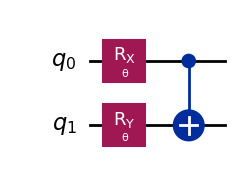

In [33]:

# Define a parameter
theta = Parameter("θ")
# Create a PQC
qc = QuantumCircuit(2)
qc.rx(theta, 0)
qc.ry(theta, 1)
qc.cx(0, 1)
qc.draw('mpl')

In [34]:
# Define a device
dev = qml.device("default.qubit", wires=2)
# Define a PQC
@qml.qnode(dev)
def pqc(params):
 qml.RX(params[0], wires=0)
 qml.RY(params[1], wires=1)
 qml.CNOT(wires=[0, 1])
 return qml.expval(qml.PauliZ(0))
# Example parameters
params = [np.pi/4, np.pi/4]
print(f"Expectation value: {pqc(params)}")

Expectation value: 0.7071067811865475


Epoch 0: Loss = 1.0042715723227107
Epoch 10: Loss = 0.34319283619800944
Epoch 20: Loss = 0.008316892799068222
Epoch 30: Loss = 0.002718184322210164
Epoch 40: Loss = 0.0013314243326187146
Epoch 50: Loss = 0.0007870747836609127
Epoch 60: Loss = 0.0005191101544538386
Epoch 70: Loss = 0.00036782413971473137
Epoch 80: Loss = 0.00027415805790161513
Epoch 90: Loss = 0.00021218211079112722


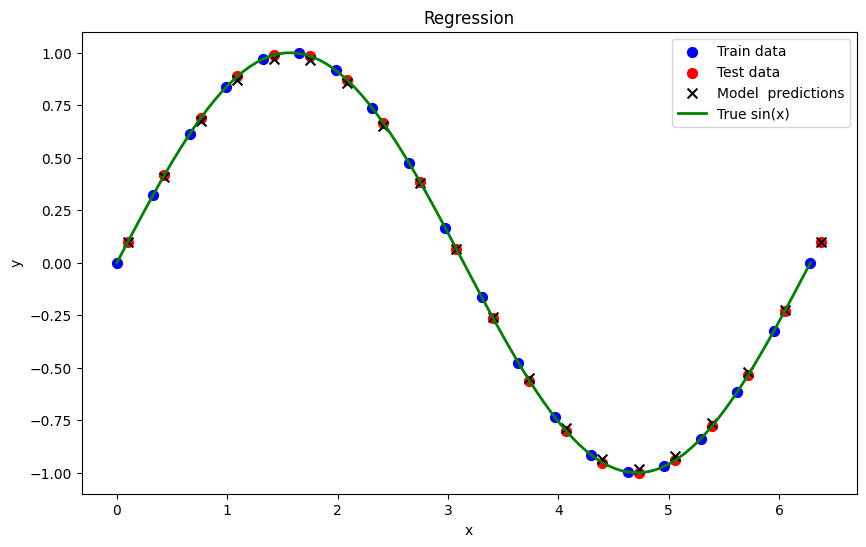

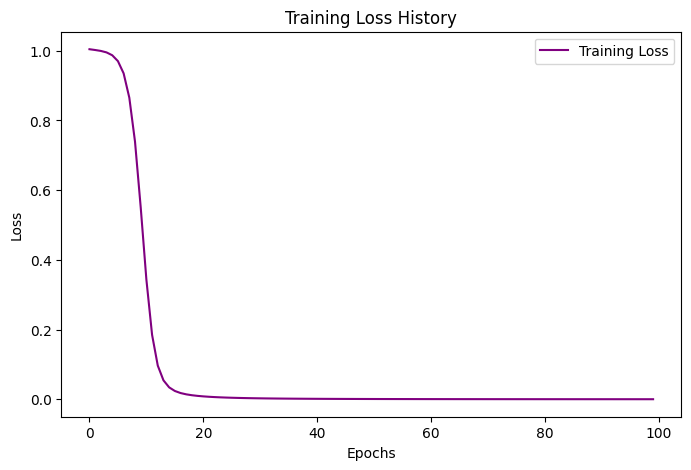

In [35]:
X = np.linspace(0, 2 * np.pi, 20)  # 20 training points
Y = np.sin(X)

X_test = np.linspace(0.1, 2 * np.pi + 0.1, 20)
Y_test = np.sin(X_test)
# Step 1: Set up the device
dev = qml.device("default.qubit", wires=1)
# Step 2: Define the quantum model
@qml.qnode(dev)
def quantum_model(x, params):
  """Quantum model"""
# Encode the input data as a single RX rotation
  qml.RX(x, wires=0)
# Apply a single layer of trainable gate
  qml.Rot(params[0], params[1], params[2], wires=0)
# Measure the expectation value of the PauliZ operator
  return qml.expval(qml.PauliZ(wires=0))

# Step 3: Define the loss function
def loss(params):
  predictions = [quantum_model(x, params) for x in X]
  return np.mean((np.array(predictions) - Y) ** 2)
# Step 4: Set up the optimizer and parameters
params = np.random.uniform(low=-0.1, high=0.1, size=3, requires_grad=True) #
optimizer = qml.GradientDescentOptimizer(stepsize=0.3)
# Training loop
num_epochs = 100
loss_history = []
for epoch in range(num_epochs):
  params, current_loss = optimizer.step_and_cost(loss, params)
  loss_history.append(current_loss)
  if epoch % 10 == 0:
      print(f"Epoch {epoch}: Loss = {current_loss}")
# Step 5: Evaluate on test data
test_predictions = [quantum_model(x, params) for x in X_test]
# Calculate smooth sine function for plotting
X_line = np.linspace(0, 2 * np.pi, 100)
Y_line = np.sin(X_line)
# Step 6: Plot results
plt.figure(figsize=(10, 6))
plt.scatter(X, Y, color="blue", label="Train data", s=50)
plt.scatter(X_test, Y_test, color="red", label="Test data", s=50)
plt.scatter(X_test, test_predictions, color="black", label="Model  predictions", s=50, marker="x")
plt.plot(X_line, Y_line, color="green", label="True sin(x)", linewidth=2)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Regression")
plt.legend()
plt.show()
# Plot loss history
plt.figure(figsize=(8, 5))
plt.plot(range(num_epochs), loss_history, label="Training Loss", color="purple")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.legend()
plt.show()


$\textbf{VQA}$

Gli Algoritmi Variazionali Quantistici (VQA) sono algoritmi ibridi che utilizzano un ottimizzatore classico per addestrare un circuito quantistico parametrizzato al fine di approssimare soluzioni per un determinato problema.

Richiedono tipicamente un numero ridotto di porte e qubit, rendendoli più resistenti al rumore. Sono iterativi: ogni iterazione include una combinazione di elaborazione quantistica e classica. 

L’output (una misura) di un’iterazione viene inviato all’ottimizzatore classico e l’ottimizzatore genera un nuovo input (un parametro) per la successiva iterazione.

$\textbf{QML}$

Le reti neurali classiche sono modelli algoritmici ispirati al funzionamento del cervello umano, progettati per riconoscere schemi nei dati e risolvere problemi complessi. Si basano su una serie di nodi interconnessi, o neuroni, organizzati in una struttura a strati. I parametri di questi modelli possono essere appresi utilizzando strategie di addestramento di machine learning o deep learning.

La motivazione alla base del Quantum Machine Learning (QML) è integrare concetti del calcolo quantistico con il machine learning classico, al fine di sviluppare nuovi e migliorati schemi di apprendimento. Le reti neurali quantistiche (QNN) applicano questo principio combinando reti neurali classiche con circuiti quantistici parametrizzati.

Le QNN, come le reti neurali classiche, sono modelli algoritmici che possono essere addestrati per individuare schemi nascosti nei dati. Questi modelli possono caricare dati classici (input) in uno stato quantistico e processarli successivamente con porte quantistiche parametrizzate da pesi allenabili. L’output, ottenuto dalla misurazione dello stato quantistico, viene utilizzato in una funzione di perdita per allenare i pesi attraverso il metodo di backpropagation.

$\textbf{BP}$

Molte proposte sperimentali per dispositivi quantistici rumorosi di scala intermedia (NISQ) prevedono l’addestramento di un circuito quantistico parametrizzato mediante un ciclo di ottimizzazione classico. Tali algoritmi ibridi quantistici-classici sono particolarmente popolari per applicazioni in simulazione quantistica, ottimizzazione e machine learning. A causa della loro semplicità ed efficienza hardware, i circuiti randomici vengono spesso proposti come ipotesi iniziali per esplorare lo spazio degli stati quantistici.

La dimensione esponenziale dello spazio di Hilbert e la complessità nella stima del gradiente rendono questa scelta inadeguata per algoritmi ibridi quantistici-classici che operano su più di pochi qubit. In particolare, per una vasta classe di circuiti quantistici parametrizzati ragionevoli, la probabilità che il gradiente lungo una qualsiasi direzione significativa sia diverso da zero, con una precisione fissata, è esponenzialmente piccola in funzione del numero di qubit. Argomentiamo che questo è correlato alla caratteristica di 2-design dei circuiti casuali e che è necessario studiare soluzioni a questo problema.

I barren plateaus sono un fenomeno nei circuiti quantistici parametrizzati (PQC) in cui i gradienti della funzione costo si annullano esponenzialmente all’aumentare del numero di qubit, rendendo difficile l’addestramento degli algoritmi quantistici variazionali.

Cause possibili sono;

Inizializzazione casuale: I PQC con parametri casuali generano distribuzioni altamente uniformi nello spazio di Hilbert

Concentrazione della misura: ll’aumentare del numero di qubit, la magnitudine del gradiente si concentra intorno a zero, un effetto legato alla geometria ad alta dimensionalità dello spazio dei parametri

Espressività: Circuiti altamente espressivi accentuano i barren plateaus creando distribuzioni uniformi nello spazio degli stati.

Strategie di mitigazione possibili:

Ansatz strutturati: Utilizzare ansatz specifici per il problema, evitando circuiti casuali o troppo espressivi

Addestramento per strati: Allenare il circuito aggiungendo strati progressivamente

Pre-addestramento classico: Usare tecniche classiche per inizializzare i parametri vicino a soluzioni ottimali

Progettazione della funzione costo: Riformulare le funzioni costo per concentrarsi su parti specifiche dello spazio delle soluzioni

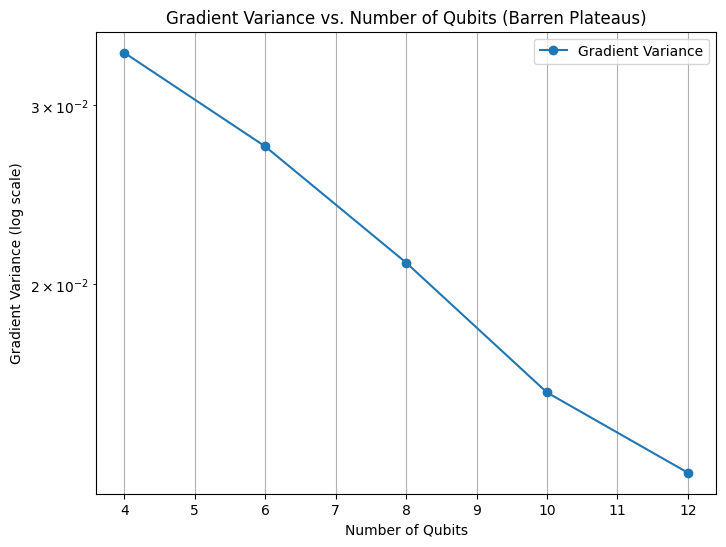

In [36]:
np.random.seed(42)


def random_layer(weights, wires):
    """Applies a random layer of single-qubit rotations followed by entangling CNOT gates."""
    for i in range(len(wires)):
        qml.RX(weights[i, 0], wires=wires[i])
        qml.RY(weights[i, 1], wires=wires[i])
        qml.RZ(weights[i, 2], wires=wires[i])
    for i in range(len(wires) - 1):
        qml.CNOT(wires=[wires[i], wires[i + 1]])

def pqc(weights):
    """Parameterized Quantum Circuit (PQC)."""
    random_layer(weights, wires=range(len(weights)))

def cost_function(weights):
    """Cost function based on the expectation value of Z on the first qubit."""
    dev = qml.device("default.qubit", wires=weights.shape[0])
    
    @qml.qnode(dev)
    def circuit(weights):
        pqc(weights)
        return qml.expval(qml.PauliZ(0))
    
    return circuit(weights)

def compute_gradient(weights):
    """Compute the gradient of the cost function with respect to weights."""
    dev = qml.device("default.qubit", wires=weights.shape[0])
    
    @qml.qnode(dev)
    def circuit(weights):
        pqc(weights)
        return qml.expval(qml.PauliZ(0))
    
    grad_fn = qml.grad(circuit)
    return grad_fn(weights)

num_qubits = [4, 6, 8, 10, 12]
num_samples = 50  # Number of random initializations
gradient_variances = []

for n in num_qubits:
    variances = []
    for _ in range(num_samples):
        # Random initialization of weights
        weights = np.random.uniform(0, 2 * np.pi, (n, 3))
        gradients = compute_gradient(weights)
        variances.append(np.var(gradients))
    gradient_variances.append(np.mean(variances))

plt.figure(figsize=(8, 6))
plt.plot(num_qubits, gradient_variances, marker="o", label="Gradient Variance")
plt.yscale("log")
plt.xlabel("Number of Qubits")
plt.ylabel("Gradient Variance (log scale)")
plt.title("Gradient Variance vs. Number of Qubits (Barren Plateaus)")
plt.grid(True)
plt.legend()
plt.show()

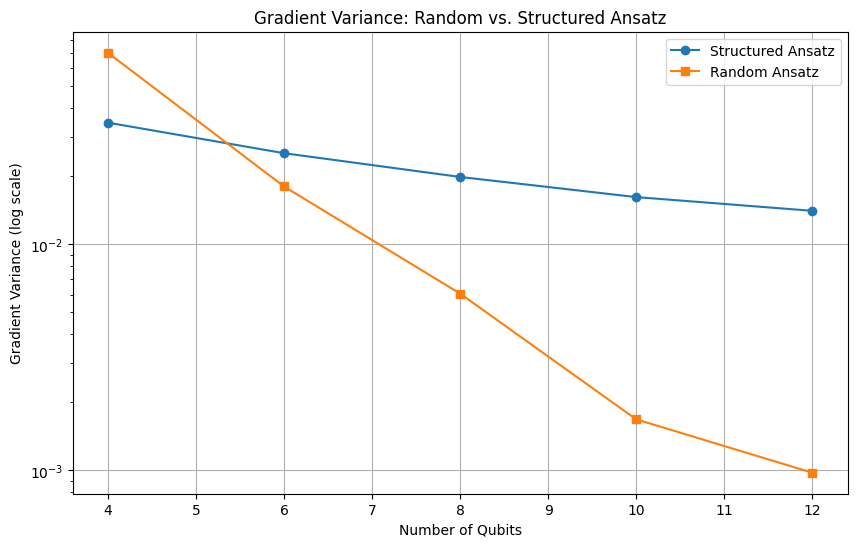

In [37]:
def structured_ansatz(weights, wires):
    """Structured Ansatz with a problem-specific layer structure."""
    for i in wires:
        qml.RY(weights[i], wires=i)  # Apply a single rotation per qubit

    # Entangling gates with nearest-neighbor pattern
    for i in range(len(wires) - 1):
        qml.CNOT(wires=[i, i + 1])

    # Wrap-around CNOT for cyclic entanglement
    qml.CNOT(wires=[len(wires) - 1, 0])

def cost_function_structured(weights):
    """Cost function for the structured ansatz."""
    dev = qml.device("default.qubit", wires=len(weights))
    
    @qml.qnode(dev)
    def circuit(weights):
        structured_ansatz(weights, wires=range(len(weights)))
        return qml.expval(qml.PauliZ(0))
    
    return circuit(weights)

def compute_gradient_structured(weights):
    """Compute the gradient of the structured ansatz."""
    dev = qml.device("default.qubit", wires=len(weights))
    
    @qml.qnode(dev)
    def circuit(weights):
        structured_ansatz(weights, wires=range(len(weights)))
        return qml.expval(qml.PauliZ(0))
    
    grad_fn = qml.grad(circuit)
    return grad_fn(weights)

## Compare Structured Ansatz and Random Ansatz
num_qubits = [4, 6, 8, 10, 12]
num_samples = 50
gradient_variances_random = []
gradient_variances_structured = []

# Analyze the random ansatz
for n in num_qubits:
    variances = []
    for _ in range(num_samples):
        weights = np.random.uniform(0, 2 * np.pi, (n, 3))  # Random weights
        gradients = compute_gradient(weights)
        variances.append(np.var(gradients))
    gradient_variances_random.append(np.mean(variances))

# Analyze the structured ansatz
for n in num_qubits:
    variances = []
    for _ in range(num_samples):
        weights = np.random.uniform(0, 2 * np.pi, n)  # Random weights
        gradients = compute_gradient_structured(weights)
        variances.append(np.var(gradients))
    gradient_variances_structured.append(np.mean(variances))

## Plot the result

plt.figure(figsize=(10, 6))
plt.plot(num_qubits, gradient_variances_random, marker="o", label="Structured Ansatz")
plt.plot(num_qubits, gradient_variances_structured, marker="s", label="Random Ansatz")
plt.yscale("log")
plt.xlabel("Number of Qubits")
plt.ylabel("Gradient Variance (log scale)")
plt.title("Gradient Variance: Random vs. Structured Ansatz")
plt.grid(True)
plt.legend()
plt.show()

$\textbf{SYMMETRIES}$

Se l'Hamiltoniana rispetta determinate simmetrie, c'è una riduzione dello spazio di Hilbert, in quanto l'ansatz evita gli stari che rompono la simmetria, e dunque si può concentrare l’ottimizzazione in sottospazi significativi più piccoli.
Un modo per mitigare i BP può essere proprio ne rispettare determinate simmetrie, ad es. simmetria rotazionale (applicare rotazioni uniformi a tutti i qubit) o simmetria traslazionale (utilizzare schemi di entanglement nearest-neighbor).

QUINDI E' IMPORTANTE LA SCELTA DELLA PARAMETRIZZAZIONE E DELLO STATO INIZIALE. Il noyse causa rottura della simmetria, che origina BP.


$\textbf{NOTAZIONE}$


$ \textit{H} = \otimes_{m} H_m$ , $dim(\mathcal{H}) = \Pi_m dim(\mathcal{H}_m)$, con $\mathcal{H}_m$ indichiamo un Q-Bit o un gruppo di qbit.

Indichiamo il canale quantistico che agisce sui Q-bit $\Phi_{\vec{\theta}}$. La funzione di costo che viene minimizzata è $\mathcal{L}_{\rho, k}=Tr[\Phi(\rho)H]$, con H osservabile. Il BP può essere visto dalla varianza di $\mathcal{L}: \textbf{V}_{\rho,H}(\theta)$. Nello specifico, c'è un BP se $\textbf{V} \propto O(e^{-\beta n})$ con n numero di QBIT.

Per un sistema layered: $\Phi_{\theta}= \mathcal{U_{L+1} \circ E_L \circ U_{L-1} \circ ... \circ E_1}$, dove $\mathcal{U_i}$ sono operatori unitari e $\mathcal{E_i}$ operatori qualsiasi, chiamati "strettamente contrattivi" se($\|E_i\| < 1$).

Lo spazio $H$ può essere suddiviso in sottosistemi locali. Questa suddivisione di $H$ induce una corrispondente partizione dello spazio $B$ degli operatori su $H$. Gli operatori in $B$ vengono raggruppati in sottospazi $B_\kappa$, ciascuno identificato da un vettore binario $\kappa$ (con $\kappa \in \{0, 1\}^M$), che indica su quali sottosistemi locali gli operatori agiscono non trivialmente (dove $\kappa_m = 1$).


Se $\mathcal{B}$ è lo spazio degli operatori limitati su $\mathcal{H}$ , tutte le componenti dei sistemi a strati mappano $\mathcal{B}$ in se stesso. Inoltre $\mathcal{B}$ preserva la suddivisione in sottosistemi di $\mathcal{H}$.

Lo spazio $B$ è scomposto come somma diretta:
$$
B = \bigoplus_{\kappa \in \{0,1\}^M} B_\kappa.
$$
La dimensione di ciascun sottospazio $B_\kappa$ è data da:
$$
d_\kappa = \prod_m (d_m^2 - 1)^{\kappa_m},
$$
dove $d_m$ rappresenta la dimensione del sottosistema $H_m$. Il caso speciale $\kappa = 0$ corrisponde a operatori banali (costanti).



Un operatore $A \in B$ si dice \emph{$\kappa$-locale} se appartiene a $B_\kappa$. A ciascun operatore si associa un vettore di località $\ell_A \in \mathbb{R}^{2^M}$, che descrive quanto l'operatore è distribuito nei vari sottospazi $B_\kappa$. Il vettore di località $\ell_A$ è definito come un vettore di dimensione pari al numero di sottospazi in cui lo spazio $B$ è suddiviso. Ogni componente $(\ell_A)_\kappa$ rappresenta la proiezione dell'operatore $A$ sul sottospazio $B_\kappa$. Questa formula misura la somma dei quadrati delle proiezioni dell'operatore $A$ sugli elementi della base $\{B_j\}_j$, normalizzata rispetto alla dimensione del sottospazio.Questo vettore è calcolato utilizzando una base ortonormale hermitiana $\{B_j\}$ di $B_\kappa$, e gli elementi di $\ell_A$ sono definiti come:
$$
(\ell_A)_\kappa = \frac{\sum_{j=1}^{d_\kappa} \text{Tr}[B_j A]^2}{d_\kappa}.
$$


Con $d_k=dim(\mathcal{B}_k)= \Pi_m (d^2_m-1)$, con $\mathcal{B}_j$ sono una base di $\mathcal{B}_k$. 



Se A è un operatore locale il vettore di località assume la forma più semplice: $(\ell_A)_\lambda = \delta_{\kappa,\lambda} \|A\|_2$

A questo punto siamo interessati a capire quando un operatore lineare che agisce su B preserva la località dello spazio, cioè quanto due sottospazi di B sono messi in comunicazione da un operatore lineare. Questo è importante perché è proprio ciò che causa il rumore: mettere in comunicazione spazi di Hilbert che non vorremmo comunicassero e fa si che il Barren Plateu diventi più importante.

Quando si considera una mappa lineare $\Lambda: B \to B$, si può misurare quanto la mappa preserva o trasferisce la località tra i sottospazi $B_\kappa$ e $B_\lambda$. Questo è rappresentato da una matrice di trasferimento di località $T$, i cui elementi sono definiti come:
$$
T_{\kappa,\lambda} = \frac{1}{d_\kappa} \sum_{j=1}^{d_\kappa} (\ell_{\Lambda(B_j)})_\lambda,
$$
dove $\ell_{\Lambda(B_j)}$ è il vettore di località associato all'immagine di $B_j$ sotto $\Lambda$.
se $\Lambda$ preserva la località, $T= I$. In questo senso, assumiamo che gli $\mathcal{U}$ siano locali, $\mathcal{E}$ no. Dunque gli E rappresenteranno il rumore ed eventualmente gli entanglement, mentre le U rappresenteranno le rotazioni e le operazioni quantistiche tra gruppi di BIt.

La matrice di trasferimento di località $T$ descrive come una mappa lineare $\Lambda : B \to B$ trasferisce "località" tra i sottospazi $B_\kappa$.
$(\ell_{\Lambda(B_j)})_\lambda$ è la componente $\lambda$-esima del vettore di località associato all'immagine di $B_j$ sotto la mappa $\Lambda$. Ogni elemento $T_{\kappa,\lambda}$ rappresenta l'interazione tra il sottospazio $B_\kappa$ (riga $\kappa$) e il sottospazio $B_\lambda$ (colonna $\lambda$). Valori elevati di $T_{\kappa,\lambda}$ indicano un forte trasferimento di località tra i due sottospazi, mentre valori piccoli indicano che la mappa $\Lambda$ preserva maggiormente la separazione tra di essi.

La matrice $T$ può essere organizzata in blocchi per evidenziare meglio le interazioni tra gruppi di sottospazi. Ad esempio, se i sottospazi $B_\kappa$ sono raggruppati in modo gerarchico, la matrice $T$ può essere scritta come:
$$
T =
\begin{bmatrix}
T^{(1,1)} & T^{(1,2)} & \cdots & T^{(1,n)} \\
T^{(2,1)} & T^{(2,2)} & \cdots & T^{(2,n)} \\
\vdots    & \vdots    & \ddots & \vdots    \\
T^{(n,1)} & T^{(n,2)} & \cdots & T^{(n,n)}
\end{bmatrix},
$$
dove i blocchi diagonali $T^{(i,i)}$ rappresentano la preservazione della località all'interno di ciascun gruppo di sottospazi, mentre i blocchi fuori diagonale $T^{(i,j)}$ con $i \neq j$ descrivono il trasferimento di località tra gruppi distinti. Questa riorganizzazione consente un'analisi dettagliata della struttura locale preservata o modificata dalla mappa $\Lambda$.



????   Per via dell'entanglemet, che causa decorenza, un QC può essere estremamente efficiente in un sottosistema, ma inefficiente nel complessivo.
Vale $ TD=(T^{+} D)^t$, con $D_{k,l} = \delta_{k,l}d_k$. Così definiamo il prodotto scalare in $R^{2^M}$: $$(a,b)=a^t D^{-1} b=\sum_{k} \frac{a_k b_k }{d_k}$$


In [1]:
from IPython.display import Image, display

# Percorso dell'immagine
image_path = "/Users/sebastianopian/Documents/Uni/Magistrale/QC.exam/Screenshot 2025-01-22 alle 11.21.30.png"

# Visualizza l'immagine
display(Image(filename=image_path))

FileNotFoundError: [Errno 2] No such file or directory: '/Users/sebastianopian/Documents/Uni/Magistrale/QC.exam/Screenshot 2025-01-22 alle 11.21.30.png'

$\textbf{RISULTATI}$

L'obiettivo è definire una varianza, che ci aiuterà a capire il valore del barren Plateau, da cui grazie a calcoli analitici e numerici riusciremo a stabilire un limite minimo per circuiti molto profondi. In pratica avremo uno strumento per quantificare la comparsa del barren plateau in circuiti profondi (a molti layer???) e non.

${\small \textbf{Varianza Analitica}}$

L è il numero dei layers. $E_{\theta}\{.\}$ rappresenta il valore di aspettazione rispetto al parametro $\theta$.
Vale: $E_{\theta}(Tr[\mathcal{U}_{\theta}(\rho)H]^2) = (l_{\rho},l_H)$. Dunque, termini di località diversa non contribuiscono insieme alla varianza, ma si sommano semplicemente.
In generale: $E_{\theta}(Tr[\Phi_{\theta}(\rho)H]^2) = (l_{\rho}, \Pi_{l=1}^{L}T_l l_H)$, dunque: 

$ \textbf{V}_{\rho,H}^L = (l_{\rho}, \Pi_{l=1}^{L}T_l l_H) -\frac{Tr[H]^2}{d^2}$.

Questa formula è utile ma inutilizzabile per grandi profondità a causa della sua complessita computazionale, ciò non di meno sarà usata per ricavare il limite a profondità grandi.

$\textbf{CIRCUITI "PROFONDI"}$

Per circuiti profondi, il contributo degli autovalori $T_l$ diventa dominante, da questo fenomeno l'interazione tra la parte unitaria e quella non unitaria da' luogo al fenomeno dell'$\textit{assorbimento}$.
Considereremo circuiti dove $\mathcal{E_l = E}$ e dove tutti gli osservabili H hanno traccia nulla, in modo che il secondo termine della varianza sia uguale a zero e che scompaia la sommatoria in favore di L. 

Dunque abbiamo una matrice T con tutti gli elementi maggiori o uguali a zero. La parte interessante è che la matrice T può essere scomposta diagonalmente in blocchi essenziali (vedi fig.) e non. In particolare sottospazi di B diversi sono messi in comunicazione dai diversi blocchi essenziali di T. Allora:  $\textbf{V}_{\rho,H}^L = (l_{\rho}, T_{l_H}^L)$.
Definiamo come $\mathcal{B_z = \oplus_{k\in T_z} B_k }$ e, dato $A \in \mathcal{B}$, 

$(l_A)_z = \sum_{k\in T_z} (l_A)_k$.


T gode di tre proprietà: la prima è che i blocchi messi in comunicazione da questa matrice preservano la loro località se trasformati dai canali $\mathcal{E}$, la seconda è che il suo blocco $\mathcal{B_0}$ forma sempre una componente essenziale di T che indichiamo con $\mathcal{T_{0}}$, la terza è che questa matrice è sempre contrattiva, cioè $\mathcal{\rho (T_{z}) \leq 1} \rightarrow (v_z)_k = 1  \forall k$.

Se $L --> \infty $, 
$V_\infty^{\rho,H} = \sum_z (\ell \rho_z, w_z)(\ell_H)_z + (\ell \rho_z, w_z)(A \ell_H)_z$. Dove $w_z$ è autovalore destro (???) di $T_z$.

Semplificando ulteriormente il problema al caso in cui il canale epsilon è formato da rumore sui singoli rumori e da canali unitari, $\mathcal{E = N \cdot W}$, allora la varianza assume la forma al limite:

$V_\infty^{\rho,H} = \sum_z \left( \frac{(\ell \rho)_z (\ell_H)_z}{d_z} + \frac{(\ell \rho)_z (A \ell_{H})_z}{d_z} \right).$

Sotto le assunzioni fatte, vale: 
$$
\|\frac{1}{L}\sum_l V_{\rho,H}^L - V_{\rho,H}^{\inf}\| \simeq  e^{-{\beta L}} \|H\|^2 .
$$
Se tutti i blocchi sono aperiodici inoltre: $\| V_{\rho,H}^L - V_{\rho,H}^{\inf}\| \simeq  e^{-{\beta L}} \|H\|^2$. 
In generale, non è detto che la varianza converga ad un valore ma almeno rimane limitata.

((As a reminder, in order for this structure to arise, the invariant subspaces of U† θ and E† have to be well-aligned, so that non-trivial subspacesBz ⊂Barepresent3. ???? CHE VUOL DIRFE CIOE COME LO RICAVIAMO=?))

Questo mette in evidenza come alcuni sottospazi si comportano da attrattori per la varianza(????). A è la matrice di assorbimento che quantifica il contributo di questi termini (non negativi). 
Se $\mathcal{E = W \cdot W^+}$, con W unitario,  $V_\infty^{\rho,H}= \sum_z \frac{(l_{\rho})_z(l_H)_z}{d_z}$, che in alcuni casi (???) può diventare
$V_\infty^{\rho,H}= \sum_z \frac{(\|\rho\|^2 - 1/d) (\|H\|^2 - Tr[H]^2/d)}{d^2- 1}$, da cui si può vedere (????) la presneza di BP per $\|H\|\simeq d$.

Se $\|\mathcal{E(A)}\| < \|A\|$ per un A, $V_\infty^{\rho,H}=\frac{(A l_{H})_0}{d} $, e se il canale è unitario, vale 0. In generale $V\simeq 1/d$.
L'interazione tra i Layer unitari e rumorosi propaga $\mathcal{E}$ alle componenti irriducibili, i canali unitari risentono maggiormente di questo effetto in quanto manca il termine di assorbimento.

((Da quello che ho capito la varianza tende subito al valore di massimo per come sono fatte. Abbiamo visto che per qualche motivo il termine dominante è dato dalla matrice di assorbimento che dopo abbiamo chiamato A. Infine, possiamo dire che date queste due cose, tanto più grande è il valore di A sullo spazio vettoriale, il valore di A è tanto maggiore tanto più grande è il centramento tra i vari canali quantistici dunque tanto piu grandi sono i sottospazi essenziali. Da cui la necessita di centrare il piu possibile questi spazi.))


$\textbf{CIRCUITI "PICCOLI"}$

Non possiamo più in questo caso assumere che la convergenza sia raggiunta da subito e le approssimazioni fatte non valgono più. Dovremo limitarci a cercare un lower bound per $V^L$. Il trucco è studiare diverse situazioni in cui la varianza converge velocemente. La richiesta è che $\beta L \simeq log(n)$, ovvero che il circuito abbia pochi layer, in questo modo $V^{\infty}$ non è mai raggiunto. $\beta$ dipende dalle correlazioni non locali. 

((In pratica chiediamo che i sottospazi siano mischiati lentamente, in maniera tale che lo stato stazionario non sia mai raggiunto.))

Questa condizione di lentezza è data dal seguente teorema:

Dati $\mathcal{E_{l}}, \mathcal{T_{l}}$ e $\alpha_l= min_{\mathcal{k} \in K}(T_l)_{\mathcal{k,k}}$. allora:

$V_L^{\rho,H} \geq   \alpha^L (l_{\rho},l_{\mathcal{K(H)}})$

Dove $\mathcal{K}$ è il proiettore su  $\mathcal{B}_K = \oplus_{\mathcal{k}\in K} \mathcal{B_k}$ e $\alpha$ è la media degli $\alpha_l$.

Inoltre, se: $  \alpha >0 \ e \ L \simeq logn \ \ \ o  \ \ \ \alpha= 1 - f(n,L) \ con \ f\simeq log(n)/L$, allora:

$$V_L^{\rho,H} \geq  F(n) (l_{\rho},l_{\mathcal{K(H)}})$$ 
dove $F \simeq 1/poly(n)$. 
La condizione 1 assicura l'assenza di concentrazione nei circuiti non profondi, la 2 per i profondi che sono a livello effettivo piccoli(???). Questi risultati sono stati ottenuti per T circa I, simile alla condizione dei piccoli angoli.

$\textbf{SMALL ANGLE INITIALIZATION}$

Consideriamo un LQC, in assenza di concentrazione e data una distribuzione iniziale. Tipicamente questa (???) è molto "peaked" attorno a 0 e con una varianza che va come 1/L. L'idea principale per le manipolazioni successive è di prendere U vicine ad I, il che ci permette di avere una varianza ben misurabile. 

Possiamo fare una cosa simile introducendo un canale quantistico in cui i canali intermedi $\mathcal{E_{\phi_l}}$ sono parametrizzati. Le considerazioni fatte sopra sono valide per canali costanti, ma possono essere facilmente generalizzati a canali parametrizzate (finchè i $\phi_l$ sono indipendenti). Nel caso, basta usare $E\{T_\phi\}$ al posto di T, dove $T_{\phi}$ e la LTM di $\mathcal{E^+_{\phi}}$.
Valendo $V_L^{\rho,H} \geq   F(n) (l_{\rho},l_{\mathcal{K(H)}})$, se prendiamo E come un modello di rumore, le condizioni 1 e 2 del paragrafo precedente sono un modo per evitare la concentrazione. 


Sia $E_\phi(\cdot) = e^{i\phi G} \cdot e^{-i\phi G}$ una porta entangling unitaria, e siano $\mu, \sigma^2$ la media e la varianza della distribuzione di inizializzazione $P$ di $\phi$. Allora, se associato alla distribuzione $\phi$ abbiamo:
$$
\mu = 0, \quad \sigma^2 \in O\left(\frac{\log n}{\|G\|_2^2 L}\right), \quad \text{e } L \in \Omega(\log^{1+\epsilon} n),
$$
si ha:
$$
V^L_{\rho, H} \geq F(n)(\ell_\rho, \ell_H),
$$
dove $F(n) \in \Omega\left(\frac{1}{\text{poly}(n)}\right)$

Cioè vuol dire che se usiamo una porta unitaria a un parametro angolare che ha una sua PDF, e possiamo scrivere la porta come prodotto di esponenziali, la varianza degli angoli è piccola e il circuito è sufficientemente profondo, allora la varianza non si riduce a zero ma ha un valore almeno piccolo e non trascurabile.

$\textbf{NOISE AD ENTANGLEMENT}$

Osservando la struttura di A, possiamo vedere come scala la varianza come funzione del rumore e dell'entanglement. Consideriamo $\mathcal{E}_c(\rho) = (1-p)\mathcal{E}(\rho) + p\tilde{\rho}$ dove  $\tilde{\rho}$ è uno stato arbitrario, E è un canale unitario che rappresenta l'entanglement, p l'errore. Possiamo pensare a $\Phi(\rho)= (1-p)\rho + p\tilde{\rho}$ e $\mathcal{E \circ U}$ 

$V_{\inf}^{\rho,H} \geq   p^2(l_{\\tilde{\\rho}}(I-(1-p)^2T)l_H)$ 

e se T è un proiettore,

$V_{\inf}^{\rho,H} \geq (p/(2-p)-p^2)(l_{\tilde{\rho}}, Tl_H) + p^2(l_{\tilde{\rho}}, l_H)$ 

Notiamo che è scomparsa la dipendenza dallo stato iniziale. Solo i layer dopo un certo l contribuiscono sensibilmente alla varianza. (rivedere la fine del paragrafo)

 Sia $\mathcal{E}_c$ un canale quantistico con $0 < p \leq 1$, e sia $T$ la matrice di transizione associata a $\mathcal{E}_c^\dagger$. Allora:

$V_\infty^{\rho, H} = p^2 \left( \ell_{\tilde{\rho}}, \left( I - (1-p)^2 T \right)^{-1} \ell_H \right).$

In particolare, se $T$ è una proiezione, allora:

$V_\infty^{\rho, H} = \left(p^2 - p - p^2 \right) \left( \ell_{\tilde{\rho}}, T \ell_H \right) + p^2 \left( \ell_{\tilde{\rho}}, \ell_H \right)$ .

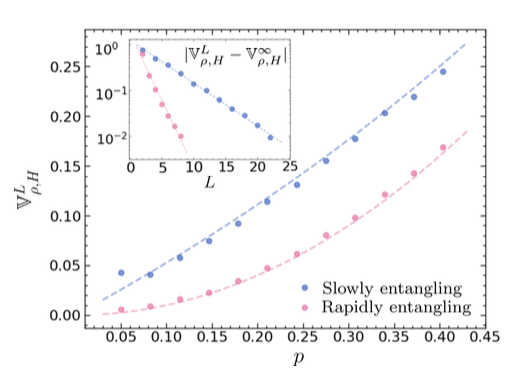

In [1]:
from IPython.display import Image, display

# Percorso dell'immagine
image_path = '/Users/sebastianopian/Documents/Uni/Magistrale/QC.exam/QC.exam/Screenshot 2025-01-22 alle 16.47.42.png'

# Visualizza l'immagine
display(Image(filename=image_path))


$\textbf{CONCLUSIONI}$

Nella descrizione della VQC in presenza di noise e circuiti non unitari, è necessario utilizzare il formalismo delle matrici non-negative, che porta alla comparsa del fenomeno dell'assorbimento, dove le componenti non contrattive possono contribuire alla varianza accoppiandosi a quelle contrattive, mostrano come l'opportuno accoppiamento di qbit ideali e rumorosi possa essere più efficiente di solo gli uni o gli altri. 

La $V^{\infty}$ può essere usata per stimare la $V^L$ in regimi di grande L e per limitarla in generale.

Per evitare i BP, si può utilizzare una strategia simile alla small angle inizialization o introdurre entanglement \"estensivo\".

$\textbf{SCELTA DEL SDR PER RISULTATI NUMERICI}$

Consideriamo i canali di rumore $E$, lo stato iniziale $\rho$ e l'osservabile $H$ usati per ottenere i risultati numerici mostrati in figura. Lo stato iniziale è fissato come $\rho = (\vert 0 \rangle \langle 0 \vert)^{\otimes n}$ per semplicità.

Il canale considerato è della forma $E_c = N \circ E$, dove:
$$
E_c(\rho) = (1-p)E(\rho) + p\tilde{\rho},
$$
e $p \in (0,1]$ rappresenta l'intensità del rumore. Il punto fisso del canale, $\tilde{\rho}$, è scelto come uno stato altamente entangled, nello specifico lo stato GHZ:
$$
\tilde{\rho} = \frac{(\vert 0 \rangle^{\otimes n} + \vert 1 \rangle^{\otimes n})(\langle 0 \vert^{\otimes n} + \langle 1 \vert^{\otimes n})}{2^n}.
$$

L'utilità è che lo stato GHZ può essere rappresentato da somme di matrici di Pauli rendendolo facilmente computabile.

La parte entangling è rappresentata in Fig. 4. Sebbene il numero di strati $L$ necessari per raggiungere la convergenza a $V^\infty_{\rho, H}$ sia logaritmico, la velocità di mescolamento dipende dalla parte entangling. Per questo motivo, $L = 8$ strati sono sufficienti nel caso di entanglement rapido, mentre $L = 20$ sono necessari per l'entanglement lento.

L'osservabile è fissato come:
$$
H = h \sum_{k=1}^n Z_k \otimes Z_{k+1},
$$
dove il fattore di normalizzazione $h$ è scelto come $h = 9/n$. Questo assicura che:
$$
(\ell_{\tilde{\rho}}, \ell_H) = 1,
$$
rendendo il confronto particolarmente semplice. 

Lo stato $\tilde{\rho}$ può essere decomposto utilizzando la base di Pauli normalizzata $\{I, X, Y, Z\}^{\otimes n}$. In particolare, usando le seguenti espressioni:
$$
\vert 0 \rangle \langle 0 \vert = \frac{I + Z}{2}, \quad 
\vert 1 \rangle \langle 1 \vert = \frac{I - Z}{2}, \quad
\vert 0 \rangle \langle 1 \vert = \frac{X + iY}{2}, \quad 
\vert 1 \rangle \langle 0 \vert = \frac{X - iY}{2},
$$
possiamo scrivere $\tilde{\rho}$ come somma di termini che coinvolgono stringhe di Pauli.

Sfruttando una generalizzazione del teorema binomiale:
$$
(A + \omega B)^{\otimes n} = \sum_{j=0}^n \omega^j \sum_{\sigma \in S} \sigma(A^{\otimes (n-j)} \otimes B^{\otimes j}),
$$
dove $\omega \in \mathbb{C}$ e $\sigma$ rappresenta una permutazione degli ordini dei qubit, otteniamo che:
$$
\tilde{\rho} = \frac{1}{2^{n/2}} \sum_{j=0}^{\lfloor n/2 \rfloor} \sum_{\sigma \in S} \sigma(I^{\otimes (n-2j)} \otimes Z^{\otimes 2j}) + (-1)^j \sigma(X^{\otimes (n-2j)} \otimes Y^{\otimes 2j}).
$$

Come si nota da questa espressione, $\tilde{\rho}$ ha componenti non nulle solo sulle stringhe di Pauli non banali su tutti i qubit o su un numero pari di qubit. Infine, l'osservabile $H$ scelto consente una semplice verifica dello scaling di $V^\infty_{\rho, H}$, con ogni termine che contribuisce in modo indipendente e normalizzato a $1/(d_m^2-1)^2 = 1/9$, dove $d_m$ è la dimensione del sottosistema.



$\textbf{NOYSE SIMULATION}$

Per simulare CQ realisticamente è necessario aggiungere rumore. 

Un modo di farlo è randomizzare classicamente parametri: ad esempio $O(\theta)= <0|U(\theta)^+ O U(\theta)|0>$ prendendo $\theta$ parametro casuale.

Un altro modo è usare il bitflip: $\rho \rightarrow \Phi(\rho)= \sum_i K_i \rho K_i^+$ con $\sum_i K_i K_i^+ =I$. Se utilizziamo $K_0 = \sqrt{1-p}I, K_1=\sqrt{p}X$. Con probabilità p un beat viene mandato nel suo strato opposto.